In [1]:
import tensorflow as tf
import numpy as np
import random

import matplotlib.pyplot as plt
%matplotlib inline

/Users/adammarblestone/Library/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
# Going to base this on: https://danijar.com/introduction-to-recurrent-networks-in-tensorflow/
# This just shows how the basic object behave, with a very simple sequence-to-sequence example
# Now let's try a shift

num_units = 25
num_layers = 1

seq_length = 50

cells = []
for _ in range(num_layers):
    cell = tf.contrib.rnn.BasicLSTMCell(num_units)  # Or LSTMCell(num_units)
    cell = tf.contrib.rnn.DropoutWrapper(cell, output_keep_prob = 0.8)
    cells.append(cell)
cell = tf.contrib.rnn.MultiRNNCell(cells) # Stack the RNN into layers

num_symbols_in_alphabet = 10
num_output_classes = 10

data = tf.placeholder(tf.float32, [None, seq_length, num_symbols_in_alphabet], name = "data") # [batch size, string size, distinct symbols]
output, state = tf.nn.dynamic_rnn(cell, data, dtype=tf.float32) # Outputs have the gates applied to m to produce h
W1 = tf.Variable(tf.random_uniform([num_units,num_output_classes],0,0.01))
output = tf.reshape(output, [-1, num_units])
predict = tf.nn.softmax(tf.matmul(output, W1))
predict = tf.reshape(predict, [-1, seq_length, num_output_classes])

target = tf.placeholder(tf.float32, [None, seq_length, num_output_classes], name = "target")

# loss = tf.losses.softmax_cross_entropy(tf.gather(target, indices = seq_length - 1, axis = 1), tf.gather(predict, indices = seq_length - 1, axis = 1))

loss = tf.losses.softmax_cross_entropy(target, predict)

trainer = tf.train.GradientDescentOptimizer(learning_rate=0.1)
updateModel = trainer.minimize(loss)

sess = tf.Session()
sess.run(tf.initialize_all_variables())

print("\nTraining.....\n")

fracs = []
losses = []
for i in range(22000):
    rand_sample = [random.randint(0, num_symbols_in_alphabet-1) for j in range(seq_length-1)] # Shift to right by 1
    rand_sample.extend([0])
    data_sample = [np.ndarray.tolist(np.identity(num_symbols_in_alphabet)[r:r+1][0]) for r in rand_sample]
    target_sample = [np.ndarray.tolist(np.identity(num_symbols_in_alphabet)[0:0+1][0])]
    target_sample.extend(data_sample[:-1])
    
    p2, _, l = sess.run([predict, updateModel, loss], feed_dict = {data:[data_sample] , target:[target_sample]})
    
    d = np.argmax(data_sample, axis=1)
    t = np.argmax(target_sample, axis=1)
    k = np.argmax(p2[0], axis=1)
    frac = float(len([g for g in [k[q] == t[q] for q in range(len(k))] if g==True]))/float(seq_length)
    
    fracs.append(frac)
    losses.append(l)
    
    if i % 1000 == 0:
        print("\nInput")
        print(d)
        print("Target")
        print(t)
        print("Prediction after %i rounds of training" % i)
        print(k)
        print([k[q] == t[q] for q in range(len(k))])
        print("\tLoss %f" % l)
        print("\tFraction correct %f" % frac)


Training.....


Input
[7 7 8 4 2 4 7 2 4 9 8 6 3 7 7 6 7 8 4 0 5 3 6 3 6 1 5 8 4 0 7 7 8 7 2 8 3
 1 4 9 1 0 3 4 6 4 2 8 2 0]
Target
[0 7 7 8 4 2 4 7 2 4 9 8 6 3 7 7 6 7 8 4 0 5 3 6 3 6 1 5 8 4 0 7 7 8 7 2 8
 3 1 4 9 1 0 3 4 6 4 2 8 2]
Prediction after 0 rounds of training
[9 1 1 9 1 2 9 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 3 3 2 9 6 9 1 1 1 1 1 1
 1 1 1 3 3 4 9 9 9 9 9 8 8]
[False, False, False, False, False, True, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, True, False, False, False, False, False, False, False, False, False, True, False]
	Loss 2.302586
	Fraction correct 0.060000

Input
[1 4 1 7 8 6 5 7 5 3 2 2 5 5 8 4 6 2 7 3 4 8 8 5 6 2 7 7 8 8 0 4 6 5 6 5 1
 6 4 2 6 4 7 1 4 2 9 6 6 0]
Target
[0 1 4 1 7 8 6 5 7 5 3 2 2 5 5 8 4 6 2 7 3 4 8 8 5 6 2 7 7 8 8 0 4 6 5 6 5
 1 6 4 2 6 4 7 1 4 2 9 6 6]
Prediction af

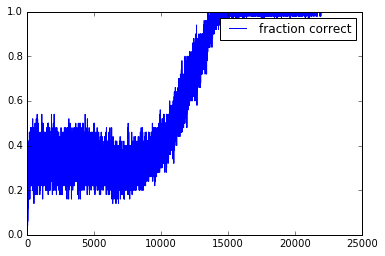

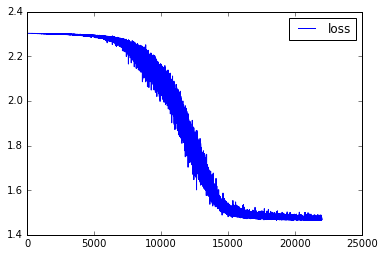

In [3]:
plt.figure()
plt.plot(fracs, label = "fraction correct")
plt.legend()
plt.figure()
plt.plot(losses, label = "loss")
plt.legend()
plt.show()